User Input Cell

In [2]:
m1 = 1.0  # Mass of body 1 (kg)
m2 = 1.0  # Mass of body 2 (kg)
x1_0 = [0.0, 1.0]  # Initial position of body 1 (m)
x2_0 = [0.0, -1.0]  # Initial position of body 2 (m)
v1_0 = [0.5, 0.0]  # Initial velocity of body 1 (m/s)
v2_0 = [-0.5, 0.0]  # Initial velocity of body 2 (m/s)
t_pred = 3.0  # Prediction time (s)

Data Generation Cell

In [3]:
import numpy as np
from scipy.integrate import odeint

G = 6.67430e-11  # Gravitational constant

def equations(y, t, m1, m2):
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
    dx1dt = vx1
    dy1dt = vy1
    dx2dt = vx2
    dy2dt = vy2

    r = np.hypot(x2-x1, y2-y1)
    ax1 = G*m2*(x2 - x1)/r**3
    ay1 = G*m2*(y2 - y1)/r**3
    ax2 = G*m1*(x1 - x2)/r**3
    ay2 = G*m1*(y1 - y2)/r**3

    return [dx1dt, dy1dt, dx2dt, dy2dt, ax1, ay1, ax2, ay2]

# Generate training data
t_train = np.linspace(0, 5, 100)
sol = odeint(equations, [*x1_0, *x2_0, *v1_0, *v2_0], t_train, args=(m1, m2))


Model Definition Cell

In [4]:
import torch
import torch.nn as nn

class PhysicsInformedNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 128),  # Input: t, m1, m2, x1_0, x2_0, v1_0, v2_0 (flattened)
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 4)   # Output: x1(t), x2(t) (flattened)
        )

    def forward(self, t, m1, m2, x1_0, x2_0, v1_0, v2_0):
        inputs = torch.cat([t, m1, m2, x1_0, x2_0, v1_0, v2_0], dim=1)
        return self.net(inputs)


Training Cell

In [5]:
import torch.optim as optim

model = PhysicsInformedNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Convert numpy data to tensors
t_tensor = torch.FloatTensor(t_train).unsqueeze(1)
t_tensor.requires_grad = True
X_true = torch.FloatTensor(sol[:, [0,1,2,3]])

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()

    X_pred = model(
      t_tensor,  # shape: (100, 1)
      torch.full((len(t_tensor),1), m1),  # shape: (100, 1)
      torch.full((len(t_tensor),1), m2),  # shape: (100, 1)
      torch.tensor(x1_0).repeat(len(t_tensor),1),  # shape: (100, 2)
      torch.tensor(x2_0).repeat(len(t_tensor),1),  # shape: (100, 2)
      torch.tensor(v1_0).repeat(len(t_tensor),1),  # shape: (100, 2)
      torch.tensor(v2_0).repeat(len(t_tensor),1))  # shape: (100, 2)


    # Data loss
    data_loss = torch.mean((X_pred - X_true)**2)

    # Physics loss (ODE residuals)
    x1_pred = X_pred[:, :2]
    x2_pred = X_pred[:, 2:]

    # Computing accelerations via autograd
    dx1dt = torch.autograd.grad(x1_pred, t_tensor, grad_outputs=torch.ones_like(x1_pred),
                               create_graph=True)[0]
    d2x1dt2 = torch.autograd.grad(dx1dt, t_tensor, grad_outputs=torch.ones_like(dx1dt),
                                create_graph=True)[0]

    dx2dt = torch.autograd.grad(x2_pred, t_tensor, grad_outputs=torch.ones_like(x2_pred), create_graph=True)[0]
    d2x2dt2 = torch.autograd.grad(dx2dt, t_tensor, grad_outputs=torch.ones_like(dx2dt), create_graph=True)[0]

    # Compute gravitational acceleration
    r_vec = x2_pred - x1_pred
    r = torch.norm(r_vec, dim=1, keepdim=True)
    ax1_true = G*m2*r_vec/r**3
    ax2_true = G*m1*(-r_vec)/r**3

    physics_loss = torch.mean((d2x1dt2 - ax1_true)**2) + \
                   torch.mean((d2x2dt2 - ax2_true)**2)

    total_loss = data_loss + physics_loss
    total_loss.backward()
    optimizer.step()


Evaluation Cell

In [6]:

from sklearn.metrics import mean_absolute_error
import numpy as np

#Generate test trajectory (ground truth)
t_test = np.linspace(0, 10, 200)
sol_test = odeint(equations, [*x1_0, *x2_0, *v1_0, *v2_0], t_test, args=(m1, m2))

t_test_tensor = torch.FloatTensor(t_test).unsqueeze(1)
m1_test_tensor = torch.full((len(t_test_tensor),1), m1)
m2_test_tensor = torch.full((len(t_test_tensor),1), m2)
x1_0_test_tensor = torch.tensor(x1_0).repeat(len(t_test_tensor),1)
x2_0_test_tensor = torch.tensor(x2_0).repeat(len(t_test_tensor),1)
v1_0_test_tensor = torch.tensor(v1_0).repeat(len(t_test_tensor),1)
v2_0_test_tensor = torch.tensor(v2_0).repeat(len(t_test_tensor),1)

# Model prediction
with torch.no_grad():
    X_pred = model(
        t_test_tensor,
        m1_test_tensor,
        m2_test_tensor,
        x1_0_test_tensor,
        x2_0_test_tensor,
        v1_0_test_tensor,
        v2_0_test_tensor
    )

# MAE
mae = mean_absolute_error(sol_test[:, [0,1,2,3]], X_pred.numpy())
print(f"Test MAE: {mae:.4e} meters")

# print positions at user-specified time t_pred
idx = (np.abs(t_test - t_pred)).argmin()

x1_pred = X_pred[idx, 0:2].numpy()  # [x1, y1] at t_pred
x2_pred = X_pred[idx, 2:4].numpy()  # [x2, y2] at t_pred

x1_true = sol_test[idx, 0:2]        # Ground truth [x1, y1]
x2_true = sol_test[idx, 2:4]        # Ground truth [x2, y2]

print(f"\nAt t = {t_pred}s:")
print(f"Predicted position of body 1: {x1_pred}")
print(f"Predicted position of body 2: {x2_pred}")
print(f"Ground truth position of body 1: {x1_true}")
print(f"Ground truth position of body 2: {x2_true}")


Test MAE: 1.2078e-01 meters

At t = 3.0s:
Predicted position of body 1: [1.50735   1.0001506]
Predicted position of body 2: [-1.5072962 -1.0002575]
Ground truth position of body 1: [1.50753769 1.        ]
Ground truth position of body 2: [-1.50753769 -1.        ]


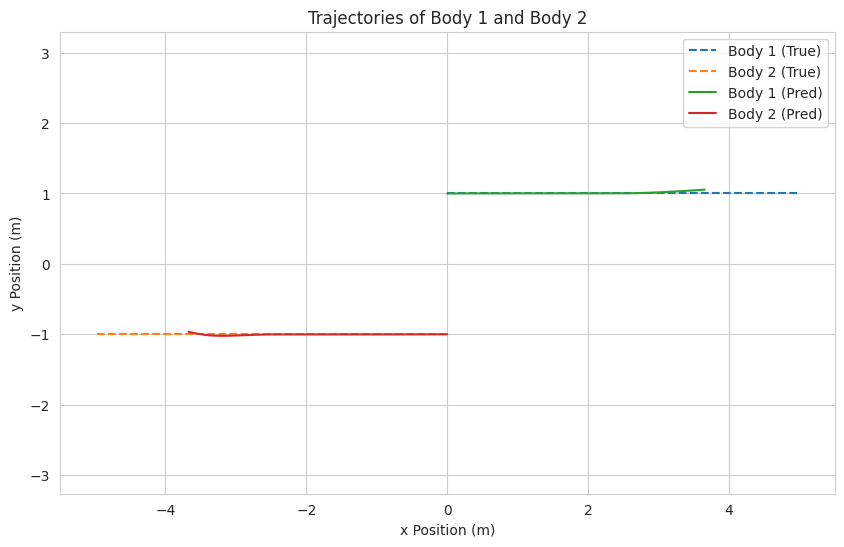

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Trajectory of the two bodies over time (Ground Truth vs. Prediction)
plt.figure(figsize=(10, 6))
plt.plot(sol_test[:, 0], sol_test[:, 1], label='Body 1 (True)', linestyle='--')
plt.plot(sol_test[:, 2], sol_test[:, 3], label='Body 2 (True)', linestyle='--')
plt.plot(X_pred.numpy()[:, 0], X_pred.numpy()[:, 1], label='Body 1 (Pred)')
plt.plot(X_pred.numpy()[:, 2], X_pred.numpy()[:, 3], label='Body 2 (Pred)')
plt.xlabel('x Position (m)')
plt.ylabel('y Position (m)')
plt.title('Trajectories of Body 1 and Body 2')
plt.legend()
plt.axis('equal')
plt.show()